In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [9]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [10]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
session.query(func.max(Measurement.date)).scalar()

'2017-08-23'

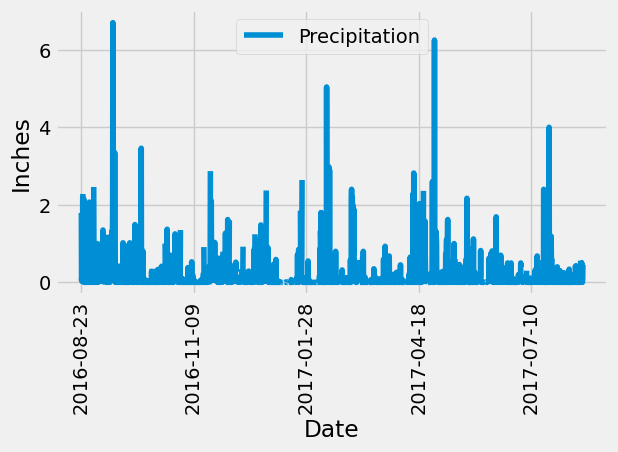

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
one_year_before = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date.between(one_year_before, most_recent_date)).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_scores, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
sorted_df = precip_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.set_index('Date', inplace=True)
sorted_df.plot(rot=90)
plt.ylabel('Inches')
plt.tight_layout()
plt.show()

In [29]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats = sorted_df.describe()
sum_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [31]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.id)).all() 

[(9,)]

In [35]:
columns = inspector.get_columns('station')
columns

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'name',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'latitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'longitude',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'elevation',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0}]

In [48]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_query = session.query(
    Measurement.station, func.count(Measurement.station).label('count')
).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
station_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_query[0].station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station).one()

print(f"Lowest Temperature: {temperature_stats.min_temp}")
print(f"Highest Temperature: {temperature_stats.max_temp}")
print(f"Average Temperature: {temperature_stats.avg_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


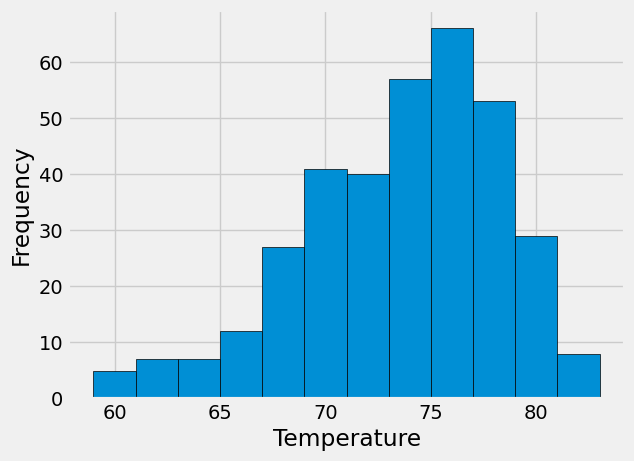

In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temperature_data = session.query(Measurement.date, Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= one_year_before
).all()
#extract values from query
temperatures = [temp.tobs for temp in temperature_data]

plt.hist(temperatures, bins=12, edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Close Session

In [16]:
# Close Session
session.close()
